<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichlet-Network/blob/main/CV_final_simclr_temperature_with_metrics_NewModel_fgsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import seaborn as sns
import torch.distributions as dist
from mpl_toolkits import mplot3d
from torch.distributions.dirichlet import Dirichlet
import torch.nn.functional as F
from scipy.stats import multivariate_normal
from scipy.stats import norm

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from scipy.stats import multivariate_normal
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     

In [2]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)                                             
cifar_transform =  transforms.Compose(
      [transforms.ToTensor(),
     transforms.Normalize(cifar_mean, cifar_std)])

In [3]:
train_in = torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                                        transform=cifar_transform)
test_in = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                                        transform=cifar_transform)
train_out_new = torchvision.datasets.CIFAR10('./data', train=True, download=True,
                                        transform=cifar_transform)
test_out_new = torchvision.datasets.CIFAR10('./data', train=False, download=True,
                                        transform=cifar_transform)
# train_out = torchvision.datasets.SVHN('./data', split ='train', download=True,
#                                         transform=cifar_transform)
# test_out = torchvision.datasets.SVHN('./data', split ='test', download=True,
#                                         transform=cifar_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./files/cifar-10-python.tar.gz to ./files/
Files already downloaded and verified


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/
! python resnet.py
from resnet import *
model = resnet18()
model.load_state_dict(torch.load('resnet18.pt'))

Mounted at /content/drive
/content/drive/My Drive


<All keys matched successfully>

In [5]:
from torch.autograd import Variable
args_logscale = False
criterion = nn.CrossEntropyLoss()
criterion.to(device)
min_pixel = -3
max_pixel = 3
args_epsilon = 0.2
model = model.to(device)

def fgsm(cnn, images, labels, eps=0.03):
    images_adv = Variable(images.data, requires_grad=True).cuda()
    images_adv.retain_grad()
    pre_logits = cnn(images_adv)
    cost = -criterion(pre_logits, labels)
    
    cnn.zero_grad()
    if images_adv.grad is not None:
        images_adv.grad.data.fill_(0)
    cost.backward()

    images_adv.grad.sign_()
    images_adv = images_adv - eps * images_adv.grad
    images_adv = torch.clamp(images_adv, min_pixel, max_pixel)
    return images_adv

def get_fgsm_images(data_loader):
  fgsm_new_images = None
  for i, ind_data in enumerate(data_loader):
    if type(ind_data) == list:
        images, labels = ind_data
    else:
        images = ind_data
    labels = Variable(labels).cuda()

    adv_images = fgsm(model, images, labels, eps=args_epsilon)
    if i == 0:
      fgsm_new_images = adv_images
    else:
      fgsm_new_images = torch.cat((fgsm_new_images, adv_images))
  return fgsm_new_images


train_out_new_loader = torch.utils.data.DataLoader(dataset=train_out_new,
                                         batch_size=64,
                                         shuffle=True,
                                         pin_memory=True)

test_out_new_loader = torch.utils.data.DataLoader(dataset=test_out_new,
                                         batch_size=64,
                                         shuffle=True,
                                         pin_memory=True)

train_out_new.data = get_fgsm_images(train_out_new_loader)
test_out_new.data = get_fgsm_images(test_out_new_loader)

train_out_new.targets = torch.tensor(np.ones(len(train_out_new.targets))*10, dtype=torch.long)
test_out_new.targets = torch.tensor(np.ones(len(test_out_new.targets))*10, dtype=torch.long)


In [6]:
# train_out.data = np.vstack(train_out.data).reshape(-1, 32, 32, 3)
train_out_new.data = train_out_new.data.cpu().detach().numpy()
train_out_new.data = train_out_new.data.reshape(-1, 32, 32, 3).astype(np.uint8)

In [7]:
train_in.data = torch.from_numpy(train_in.data)
# train_out.data = torch.from_numpy(train_out.data)

In [8]:
# train_out.targets = torch.tensor(np.ones(len(train_out.labels))*10, dtype=torch.long)
# test_out.targets = torch.tensor(np.ones(len(test_out.labels))*10, dtype=torch.long)

# train_all = train_in
# train_all.data = torch.cat((train_in.data, train_out.data))
# train_all.targets = torch.cat((torch.IntTensor(np.array(train_in.targets)), torch.IntTensor(np.array(train_out.targets))))
# train_all.data = train_all.data.cpu().detach().numpy()
# train_all.targets = train_all.targets.data.cpu().detach().numpy()
train_all = train_in
train_all.data = torch.cat((train_in.data, torch.tensor(train_out_new.data)))
train_all.targets = torch.cat((torch.IntTensor(np.array(train_in.targets)), train_out_new.targets))
train_all.data = train_all.data.cpu().detach().numpy()
train_all.targets = train_all.targets.data.cpu().detach().numpy()

In [9]:
train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

In [10]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection

In [11]:
backbone = 'resnet18'
base_encoder = eval(backbone)
simclr_model = SimCLR(base_encoder, projection_dim=128)
simclr_model.load_state_dict(torch.load('/content/drive/My Drive/CV_Project/simclr_resnet18_epoch1200.pt'))

<All keys matched successfully>

In [12]:
simclr_model = simclr_model.to(device)

In [13]:
def get_simclr_features(data, simclr_model):
    feature = simclr_model.enc(data)
    return feature

In [14]:
def get_temperatures(targets):
    temperature = targets.clone().cpu().detach()
    temperature = temperature.apply_(lambda x: 1 if (x == 10) else 5)
    return temperature.to(device)

In [15]:
def get_resnet_output(data, model, targets):
  temp = get_temperatures(targets)
  y = model.forward(data)
  try:
      exp_y = temp.unsqueeze(1) * y 
  except:
      exp_y = temp * y
  y = torch.nn.functional.softmax(exp_y, dim = 1)
  return y

In [16]:
model = model.to(device)
model = model.to(torch.float64)

In [17]:
model = model.type(torch.FloatTensor).to(device)
testdata = torchvision.datasets.CIFAR10('files/', train=False, download=True,
                                        transform=cifar_transform)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32)


Files already downloaded and verified


In [18]:
# targets is a torch tensor of targets [3,4,5] for 3 in, [10,10,10] for 3 out, [3,10,1] in,out,im
def target_alpha(targets):
  target = targets.cpu().detach().numpy()
  def gen_onehot(category, total_cat=10):
    label = np.ones(total_cat)
    label[category] = 20
    return label
  target_alphas = []
  for i in target:
    if i==10:
      target_alphas.append(torch.tensor(np.ones(10)))
    else:
      target_alphas.append(torch.tensor(gen_onehot(i)))
  return torch.stack(target_alphas).to(device)

In [19]:
# 1 for out, -1 for in
def check_in_out_lambdas(target_alphas):

  alpha_sum = target_alphas.sum(axis = 1)
  alpha_sum = alpha_sum.cpu().detach()
  lambdas =  alpha_sum.apply_(lambda x: 1 if(x==10) else -1)
  return lambdas.to(device)


In [20]:
class PriorNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)         # output_dim = 4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)

    def predict_alpha(self, x):
      src = torch.Tensor(x).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))
    
    def expected_entropy_from_alphas(self, alphas, alpha0):
        return -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
    
    def categorical_entropy_torch(self, probs):
        log_probs = torch.log(probs)
        log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
        entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
        return entropy

    def mutual_information(self, x, tar):
        
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0

        expected_entropy = self.expected_entropy_from_alphas(alphas, alpha0)
        entropy_of_exp = self.categorical_entropy_torch(probs)
        mutual_info = entropy_of_exp - expected_entropy
        return mutual_info

    def diffenrential_entropy(self, x, tar):
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

    def entropy(self, x, tar):
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret

In [22]:
augnet_path =  '/content/drive/My Drive/CV_Project/augnet_simclr_newModel_temp'
file_name = 'augnet_sim_temp_NM'
from os import truncate

class AugNet(PriorNet):

    def __init__(self, old_preds_dim, feature_dim, target_dim):
        super().__init__()
        self.y_dim = old_preds_dim
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.fc1 = nn.Linear(feature_dim, 1024)   
        self.relu = torch.nn.ReLU()
        self.fc2_1 = nn.Linear(1024, 512) 
        self.fc2_2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(10 + 256, 512) 
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256,64)
        self.fc6 = nn.Linear(64,10)
     
  

    def forward(self, features, y):

      x = self.fc1(features)
      x = self.relu(x)
      x = self.fc2_1(x)
      x = self.relu(x)
      x = self.fc2_2(x)
      x = self.relu(x)
      x = self.fc3(torch.cat((x,y), dim = 1) )
      x = self.relu(x)
      x = self.fc4(x)
      x = self.relu(x)
      x = self.fc5(x)
      x = self.relu(x)
      x = self.fc6(x)

      return x



    def predict_alpha(self, x, model, tar):
            x = torch.FloatTensor(x).unsqueeze(0) 
            x = x.to(device)
            x = x.reshape(-1, 3, 32, 32)
            features = get_simclr_features(x, simclr_model)
            t = torch.tensor(tar)
            pred_outputs = get_resnet_output(x, model, t)
            output = torch.exp(self.forward(features, pred_outputs))
            return output
    
    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet
  
    def fit(self, epoch_num, optimizer, model):
      self.train()
      loss_track = []
      train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

      for epoch in range(epoch_num):


        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):

          optimizer.zero_grad()
          target = target.to(device)
          data= data.type(torch.FloatTensor).to(device)
          features = get_simclr_features(data,simclr_model)
          features = features.detach().requires_grad_(False)
          y = get_resnet_output(data,model,target)
          y = y.detach().requires_grad_(False)

          # predict alpha
          target_a = target_alpha(target)
          target_a = target_a.to(device)
          out = self.forward(features, y)
          output_alpha = torch.exp(out)

          dirichlet1 = Dirichlet(output_alpha)
          dirichlet2 = Dirichlet(target_a)
          lambdas = check_in_out_lambdas(target_a)
          sgm_alpha = torch.sigmoid(output_alpha) 
        
          loss = torch.sum(dist.kl.kl_divergence(dirichlet1, dirichlet2)  + lambdas * torch.mean(sgm_alpha,1))
          loss_total += loss.item()
          loss.backward(retain_graph=True)
          optimizer.step()
            
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss_total/120000))
        loss_track.append(loss_total)

        if(epoch%4 == 0):
        
          torch.save({
              'epoch': epoch,
              'model_state_dict': self.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss_track,
              }, f"{augnet_path}/{file_name+str(epoch)+'.pth'}")
        
      return loss_track
    
    def max_prob(self, x, tar):
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values

In [23]:
dpn = AugNet(10,512,10)
dpn.to(device)
optimizer = optim.Adam(dpn.parameters(), lr=0.001)

losses = dpn.fit(32, optimizer, model)

Train Epoch: 0 	 Loss: 1.225545
Train Epoch: 1 	 Loss: 0.825308
Train Epoch: 2 	 Loss: 0.521087
Train Epoch: 3 	 Loss: 0.593606
Train Epoch: 4 	 Loss: 0.518248
Train Epoch: 5 	 Loss: 0.781920
Train Epoch: 6 	 Loss: 0.477902
Train Epoch: 7 	 Loss: 1.180928
Train Epoch: 8 	 Loss: 0.466990
Train Epoch: 9 	 Loss: 0.415900
Train Epoch: 10 	 Loss: 0.386875
Train Epoch: 11 	 Loss: 0.387094
Train Epoch: 12 	 Loss: 0.425230
Train Epoch: 13 	 Loss: 0.391734
Train Epoch: 14 	 Loss: 0.337550
Train Epoch: 15 	 Loss: 0.341542
Train Epoch: 16 	 Loss: 0.395529
Train Epoch: 17 	 Loss: 0.385398
Train Epoch: 18 	 Loss: 0.306251
Train Epoch: 19 	 Loss: 0.362082
Train Epoch: 20 	 Loss: 0.266385
Train Epoch: 21 	 Loss: 0.260858
Train Epoch: 22 	 Loss: 0.245431
Train Epoch: 23 	 Loss: 0.257413
Train Epoch: 24 	 Loss: 0.257725
Train Epoch: 25 	 Loss: 0.229277
Train Epoch: 26 	 Loss: 0.209330
Train Epoch: 27 	 Loss: 0.202912
Train Epoch: 28 	 Loss: 0.203383
Train Epoch: 29 	 Loss: 0.182020
Train Epoch: 30 	 Lo

In [24]:
test_in_cut = test_in
test_out_cut = test_out_new

In [32]:
test_in_cut.data = test_in.data[0:1000]
test_in_cut.targets = test_in.targets[0:1000]
test_out_cut.data = test_out_new.data[0:1000]
test_out_cut.targets = test_out_new.targets[0:1000]
test_in = test_in_cut
test_out = test_out_cut
test_out.data = test_out.data.cpu().detach()


In [27]:
dpn = AugNet(10,512,10)
dpn_model = torch.load('/content/drive/My Drive/CV_Project/augnet_simclr_newModel_temp/augnet_sim_temp_NM28.pth')
dpn.load_state_dict(dpn_model['model_state_dict'])
dpn.to(device)

AugNet(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1, out_features=3, bias=True)
  (relu): ReLU()
  (fc2_1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2_2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=266, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=10, bias=True)
)

In [33]:
# miscood.py

def uncertainty_score(dpn, test_data, test_targets, metrics):
  dpn.eval()
  score_lst = []
  for i in range(len(test_data)):
    x = test_data[i]
    tar = test_targets[i]
#     print(x.shape)
#     print(tar.shape)
    with torch.no_grad():
      if metrics=='DE':
        score = dpn.diffenrential_entropy(x, tar).data.cpu().numpy()[0][0]
      elif metrics=='MI':
        score = dpn.mutual_information(x, tar).data.cpu().numpy()[0]
      elif metrics=='MAXP':
        score = dpn.max_prob(x, tar).data.cpu().numpy()[0]
      elif metrics=='ENT':
        score = dpn.entropy(x, tar).data.cpu().numpy()[0]
    score_lst.append(score)
  return score_lst


def get_ood_label_score(test_in_score, test_out_score):
  score = np.concatenate([test_in_score, test_out_score])
  label = np.concatenate((np.zeros(len(test_in_score)), np.ones(len(test_out_score))))
  return label, score
  
def get_misc_label_score(dpn, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
    tar = test_label[i]
#     x = [x]
    with torch.no_grad():
      pred = dpn.predict_alpha(x, model, tar)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(torch.tensor(test_label[i]), pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

def plot_roc(label, score, label_name):
  fpr, tpr, thresholds = roc_curve(label, score)
  plt.plot(fpr, tpr, label=label_name)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)

def plot_pr(label, score, label_name):
  precision, recall, thresholds = precision_recall_curve(label, score)
  plt.plot(recall, precision, label=label_name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)


def get_auroc_aupr(label, score):
  auroc = roc_auc_score(label, score)
  precision, recall, thresholds = precision_recall_curve(label, score)
  aupr = auc(recall, precision)
  return auroc, aupr


def get_test_roc_pr(network, metrics, detect='ood'):
  test_in_score = uncertainty_score(network, test_in.data, test_in.targets, metrics)
  test_out_score = uncertainty_score(network, test_out.data, test_out.targets, metrics)
  if detect=='ood':
    label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
  elif detect=='misc':
    label_dp, score_dp = get_misc_label_score(network, test_in.data,
                                              test_in.targets, test_in_score)
  if metrics=='MAXP':
    score_dp = -score_dp

  index = np.isposinf(score_dp)
  score_dp[np.isposinf(score_dp)] = 1e9
  maximum = np.amax(score_dp)
  score_dp[np.isposinf(score_dp)] = maximum + 1

  index = np.isneginf(score_dp)
  score_dp[np.isneginf(score_dp)] = -1e9
  minimum = np.amin(score_dp)
  score_dp[np.isneginf(score_dp)] = minimum - 1

  score_dp[np.isnan(score_dp)] = 0

  auroc, aupr = get_auroc_aupr(label_dp, score_dp)
  return auroc, aupr, label_dp, score_dp

In [34]:
auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(tar)
<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(tar)
<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(tar)
<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [35]:
auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.50,0.50,0.50,0.50
AUPR,0.95,0.95,0.95,0.95


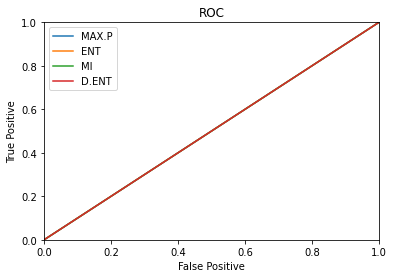

In [36]:
plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

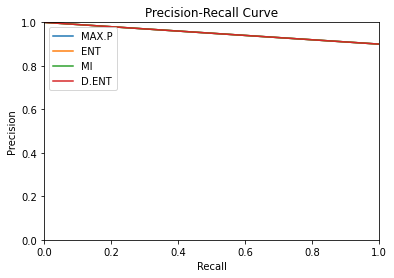

In [37]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

In [38]:
auroc_mp_ood, aupr_mp_ood, label_mp_ood, score_mp_ood = get_test_roc_pr(dpn, 'MAXP', 'ood')
auroc_ent_ood, aupr_ent_ood, label_ent_ood_ood, score_ent_ood = get_test_roc_pr(dpn, 'ENT', 'ood')
auroc_mi_ood, aupr_mi_ood_ood, label_mi_ood, score_mi_ood = get_test_roc_pr(dpn, 'MI', 'ood')
auroc_de_ood, aupr_de_ood, label_de_ood, score_de_ood = get_test_roc_pr(dpn, 'DE', 'ood')

<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(tar)
<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(tar)
<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(tar)
<ipython-input-22-171960b05ca2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [39]:
auroc_lst_ood = [auroc_mp_ood, auroc_ent_ood, auroc_mi_ood, auroc_de_ood]
aupr_lst_ood = [aupr_mp_ood, aupr_ent_ood, aupr_mi_ood_ood, aupr_de_ood]

pd.DataFrame(data=np.array([auroc_lst_ood, aupr_lst_ood]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.50,0.50,0.50,0.50
AUPR,0.75,0.75,0.75,0.75


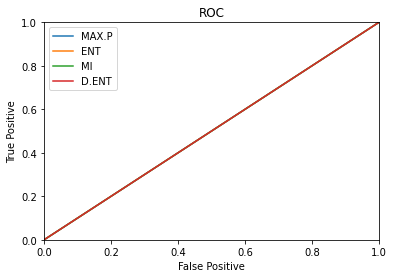

In [40]:
plot_roc(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_roc(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_roc(label_mi_ood, score_mi_ood, label_name='MI')
plot_roc(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

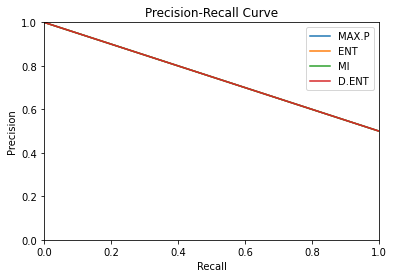

In [41]:
plot_pr(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_pr(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_pr(label_mi_ood, score_mi_ood, label_name='MI')
plot_pr(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

In [42]:
# dnn = resnet18()
# dnn.load_state_dict(torch.load('resnet18.pt'))
# auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'misc')
# auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'misc')

# auroc_lst = [auroc_mp, auroc_ent]
# aupr_lst = [aupr_mp, aupr_ent]

# pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
#              columns=['Max.P', 'Ent'], 
#              index=['AUROC', 'AUPR'])